In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import math
from scipy import interpolate
plt.rc('font',family='Times New Roman')

In [25]:
L=420e-6
H=80e-6
Pe = 0.01
DO2 = 7.63596e-6
H = 80e-6
w=20e-6
U_0 = Pe*DO2/w
umax=1.5*U_0
Tref=773
rhof=4.4908
Mwf=0.02888
x_O2=0.22


# Read COMSOL Data

## Read Centerline x from COMSOL

In [26]:
x_centerline_file_comsol=f"./output-x-centerline_timestep1e-5.txt"
with open(x_centerline_file_comsol,"r") as fp:
    lines=fp.readlines()
    header=lines[8]
header=re.split(r" +(?![t@(])",header)
header.pop(0)
header[-1]=header[-1].strip()
df_comsol_x_centerline = pd.read_csv(x_centerline_file_comsol, comment='%', sep='\\s+', header=None,names=header)
df_comsol_x_centerline.sort_values(by="x",inplace=True)
df_comsol_x_centerline.reset_index(drop=True,inplace=True)
df_comsol_x_centerline.fillna(0,inplace=True)
df_comsol_x_centerline.head()

,x,y,u (m/s) @ t=0.002,T (K) @ t=0.002,c_O2 (mol/m^3) @ t=0.002,c_CO2 (mol/m^3) @ t=0.002,u (m/s) @ t=0.004,T (K) @ t=0.004,c_O2 (mol/m^3) @ t=0.004,c_CO2 (mol/m^3) @ t=0.004,...,c_O2 (mol/m^3) @ t=0.04,c_CO2 (mol/m^3) @ t=0.04,u (m/s) @ t=0.05,T (K) @ t=0.05,c_O2 (mol/m^3) @ t=0.05,c_CO2 (mol/m^3) @ t=0.05,u (m/s) @ t=0.06,T (K) @ t=0.06,c_O2 (mol/m^3) @ t=0.06,c_CO2 (mol/m^3) @ t=0.06
0,0.000000e+00,0.00004,0.005727,773.000000,34.209695,0.000000,0.005727,773.000000,34.209695,0.000000,...,34.209695,0.000000,0.005727,773.000000,34.209695,0.000000,0.005727,773.000000,34.209695,0.000000
1,1.198662e-10,0.00004,0.005727,773.000012,34.209677,0.000003,0.005727,773.000045,34.209677,0.000008,...,34.209658,0.000040,0.005727,773.001078,34.209658,0.000040,0.005727,773.001176,34.209658,0.000040
2,2.930714e-06,0.00004,0.005707,773.303560,33.757499,0.070051,0.005707,774.108827,33.760722,0.198339,...,33.308619,0.977337,0.005707,799.356248,33.308562,0.982596,0.005707,801.757119,33.308534,0.984568
3,5.856840e-06,0.00004,0.005719,773.607293,33.305173,0.140219,0.005719,775.217908,33.311505,0.396909,...,32.407106,1.955345,0.005719,825.708247,32.406992,1.965866,0.005719,830.509510,32.406936,1.969811
4,5.858781e-06,0.00004,0.005719,773.607494,33.304872,0.140265,0.005719,775.218644,33.311207,0.397041,...,32.406508,1.955994,0.005719,825.725732,32.406394,1.966518,0.005719,830.528588,32.406338,1.970465


# Validate 

## Function Dev

In [27]:
def validate(df_comsol=df_comsol_x_centerline,time=0.002,file="x-centerline_T_O2_CO2.csv",axis='x',obj='T',refLength=L,refValue=Tref):
    path=f"../postProcessing/singleGraph/{str(time)}/{file}"
    df_dbs=pd.read_csv(path)
    df_norm_dbs=pd.DataFrame(columns=["NormalizedLength","NormalizedValue"])
    if obj=="T":
        df_norm_dbs["NormalizedLength"]=df_dbs[axis]/refLength
        df_norm_dbs["NormalizedValue"]=df_dbs[obj]/refValue
    else:
        df_norm_dbs["NormalizedLength"]=df_dbs[axis]/refLength
        df_norm_dbs["NormalizedValue"]=df_dbs[obj]
    df_norm_dbs.head()
    if obj=='T':
        comsol_label=f"T (K) @ t={time}"
    elif obj=="O2" or obj=="CO2":
        comsol_label=f"c_{obj} (mol/m^3) @ t={time}"
    df_norm_comsol=pd.DataFrame(columns=["NormalizedLength","NormalizedValue"])
    df_norm_comsol["NormalizedLength"]=df_comsol[axis]/refLength
    df_norm_comsol["NormalizedValue"]=df_comsol[comsol_label]/refValue

    interp_f=interpolate.interp1d(df_norm_comsol["NormalizedLength"],df_norm_comsol["NormalizedValue"],kind="linear")
    df_norm_comsol_interpolated=interp_f(df_norm_dbs["NormalizedLength"])

    relative_error=0.0
    num=0
    if obj=="T":
        reduce=1
    else:
        reduce=0
    for i in df_norm_dbs.index:
        benmark=df_norm_comsol_interpolated[i]
        dbs=df_norm_dbs["NormalizedValue"][i]
        if(benmark>1e-16):
            num+=1
            error=(dbs-benmark)/(benmark-reduce)  #relative to the temperature increase
            relative_error+=pow(error,2)

    relative_error=math.sqrt(relative_error)/num
    # print(f"non-zero value num: {num}")
    print(f"relative_error: {relative_error*100}%")

    df_norm_dbs_sampling=df_norm_dbs[df_norm_dbs.index%10==0]
    fig, ax = plt.subplots()
    ax.plot(df_norm_comsol["NormalizedLength"],df_norm_comsol["NormalizedValue"],label="COMSOL")
    ax.scatter(df_norm_dbs_sampling["NormalizedLength"],df_norm_dbs_sampling["NormalizedValue"],color="",marker="o",s=15,edgecolors="r",label="DBS")
    ax.set_xlabel(f"Dimensionless {axis}")
    ax.set_ylabel(f"Dimensionless {obj}")
    ax.set_title(f"{obj} centerline: DBS vs LB")
    # ax.text(0.7,0.2,f" relative error: {:.2f}%".format(relative_error_ux*100))
    ax.legend(loc="upper right")

## Validate Temperature

relative_error: 0.09754324407932462%


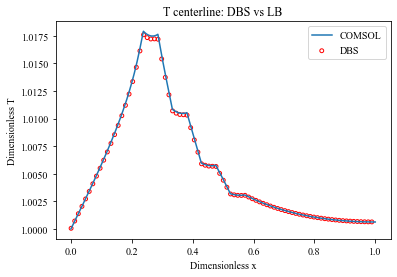

In [28]:
validate(df_comsol=df_comsol_x_centerline,time=0.002,file="x-centerline_T_O2_CO2.csv",axis='x',obj='T',refLength=L,refValue=Tref)

relative_error: 0.10055964052733837%


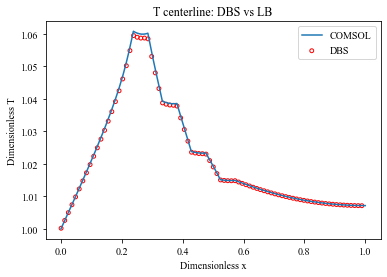

In [29]:
validate(df_comsol=df_comsol_x_centerline,time=0.004,file="x-centerline_T_O2_CO2.csv",axis='x',obj='T',refLength=L,refValue=Tref)

relative_error: 0.10251027101031461%


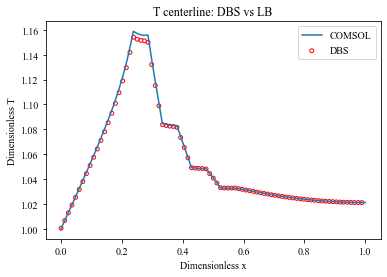

In [30]:
validate(df_comsol=df_comsol_x_centerline,time=0.006,file="x-centerline_T_O2_CO2.csv",axis='x',obj='T',refLength=L,refValue=Tref)

## Validate O2

relative_error: 1.0665743136130752%


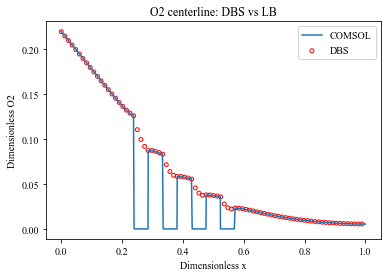

In [31]:
validate(df_comsol=df_comsol_x_centerline,time=0.002,file="x-centerline_T_O2_CO2.csv",axis='x',obj='O2',refLength=L,refValue=rhof/Mwf)

relative_error: 1.1071517135149958%


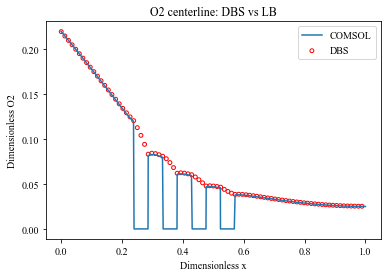

In [32]:
validate(df_comsol=df_comsol_x_centerline,time=0.004,file="x-centerline_T_O2_CO2.csv",axis='x',obj='O2',refLength=L,refValue=rhof/Mwf)

relative_error: 1.1998773805225469%


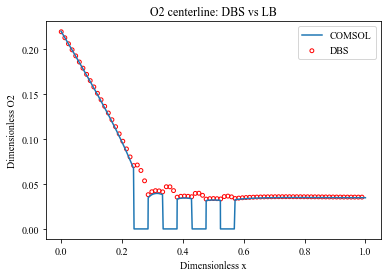

In [33]:
validate(df_comsol=df_comsol_x_centerline,time=0.006,file="x-centerline_T_O2_CO2.csv",axis='x',obj='O2',refLength=L,refValue=rhof/Mwf)

## Validate CO2

relative_error: 1.0185084623937781%


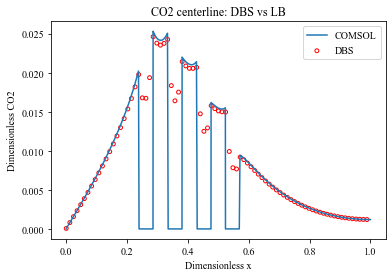

In [34]:
validate(df_comsol=df_comsol_x_centerline,time=0.002,file="x-centerline_T_O2_CO2.csv",axis='x',obj='CO2',refLength=L,refValue=rhof/Mwf)

relative_error: 1.042652420005097%


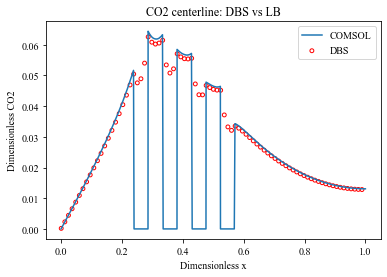

In [35]:
validate(df_comsol=df_comsol_x_centerline,time=0.004,file="x-centerline_T_O2_CO2.csv",axis='x',obj='CO2',refLength=L,refValue=rhof/Mwf)

relative_error: 1.0470510265223618%


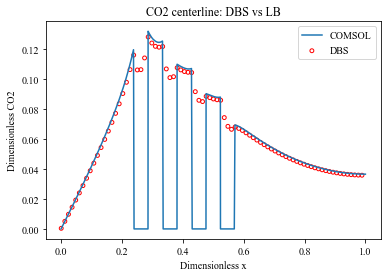

In [36]:
validate(df_comsol=df_comsol_x_centerline,time=0.006,file="x-centerline_T_O2_CO2.csv",axis='x',obj='CO2',refLength=L,refValue=rhof/Mwf)